# Getting Chicago Data

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gmaps

<IPython.core.display.Javascript object>

# Data Based Per day based on Segments

In [3]:

def getData(filename):
    df=pd.read_csv(filename,skipinitialspace=True)
    return df

df_conges=getData('Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Segment.csv')

df_segment=getData('Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Segments.csv')

%matplotlib inline


In [240]:
df_conges.head(3)
df_segment.head(3)
df_conges.tail(3)



,TIME,SEGMENTID,BUS COUNT,MESSAGE COUNT,SPEED,ID
12163278,08/02/2011 11:50:32 PM,1123,0,0,-1,8ae495ca06c6eb0004fa264ed8d5e952f7db6e13
12163279,08/02/2011 11:50:32 PM,1123,0,0,-1,8ae495ca06c6eb0004fa264ed8d5e952f7db6e13
12163280,08/02/2011 11:50:32 PM,1123,0,0,-1,8ae495ca06c6eb0004fa264ed8d5e952f7db6e13


# Displaying data

In [65]:
## Filtering data with no GPS Data

In [241]:
df_conges = df_conges[(df_conges['MESSAGE COUNT'] > 0)]
df_conges.head()

,TIME,SEGMENTID,BUS COUNT,MESSAGE COUNT,SPEED,ID
2,12/30/2014 11:50:32 PM,1,1,2,25,438597c45a69b452c41cd94eb822f5ea98574ced
3,12/30/2014 11:50:32 PM,1,1,6,25,737422daecadf090fd40901146053c442a970454
7,12/30/2014 11:50:32 PM,1,1,4,23,d3ad49a330b281923c9fafe47573d70caa63c05f
8,12/30/2014 11:50:32 PM,1,1,4,27,ed60e8c095e8517330d93c8581c0c95ccb295e11
9,12/30/2014 11:50:32 PM,1,1,5,26,029e50affd61753016d4723720c86c4500b3815b


In [3]:
import datetime as dt
format = '%m/%d/%Y %I:%M:%S %p'
df_conges['DATE'] = df_conges['TIME'].apply(lambda x: 
                                    dt.datetime.strptime(x,format).date())


In [242]:
if 'TIME' in df_conges.columns:
    df_conges = df_conges.drop(['TIME'],1)
df_conges.head()

df_conges.columns
df_conges=df_conges.rename(columns = {'BUS COUNT                ':'BUS COUNT'})
df_conges.columns

df_conges[['SEGMENTID', 'BUS COUNT','MESSAGE COUNT','SPEED']] = df_conges[['SEGMENTID', 'BUS COUNT','MESSAGE COUNT','SPEED']].astype(int)

# df_conges.head(2)
# df_conges.columns
df_segment_ID_SPEED=df_conges[["ID", "SEGMENTID",'SPEED']]
df_segment_ID_SPEED.head(2)
#df_temp.groupby('cluster')['time'].mean()

,ID,SEGMENTID,SPEED
2,438597c45a69b452c41cd94eb822f5ea98574ced,1,25
3,737422daecadf090fd40901146053c442a970454,1,25


In [243]:
import numpy as np
segmentid_groupby=df_segment_ID_SPEED.groupby(['SEGMENTID'])
segment_speed=segmentid_groupby.aggregate(np.mean)
segment_speed.reset_index(level=0, inplace=True)
segment_speed.head(2)
df_segment_speed = pd.merge(left=segment_speed,right=df_segment, how='left', left_on='SEGMENTID', right_on='SEGMENTID')
df_segment_speed.head(2)

,SEGMENTID,SPEED,STREET,DIRECTION,FROM_STREET,TO_STREET,LENGTH,STREET_HEADING,COMMENTS,START_LONGITUDE,START_LATITUDE,END_LONGITUDE,END_LATITUDE,CURRENT_SPEED,LAST_UPDATED
0,1,23.054939,55th,EB,Pulaski,Central Park,0.5,W,NaN,-87.723160,41.793067,-87.713607,41.793141,22,2016-02-13 19:30:52.0
1,2,20.657741,55th,EB,Central Park,Kedzie,0.5,W,NaN,-87.713607,41.793141,-87.703555,41.793377,16,2016-02-13 19:30:52.0


In [ ]:
# Speed w.r.t. Segments

In [253]:
import folium
df_segment_speed=df_segment_speed.rename(columns = {'START_LONGITUDE':'LONGTITUDE','START_LATITUDE':'LATITUDE'})
df_segment_speed.head(1)
def generateMap(df,name):
    CHICAGO_COORDINATES = (41.8369, -87.6847) 
    chicago_map = folium.Map(location=CHICAGO_COORDINATES,zoom_start=12)
    chicago_map.lat_lng_popover()
    for i in range(0, df.shape[0]):
        speed=(df.irow(i))['SPEED']
        lat=(df.irow(i))['LATITUDE']
        lng=(df.irow(i))['LONGTITUDE']
        chicago_map.simple_marker(location=[lat, lng],popup='SPEED:' + str(speed),clustered_marker = True)
    chicago_map.create_map('chicago_map_'+name+'.html')
    chicago_map.render_iframe = True
    return chicago_map
chicago_map=generateMap(df_segment_speed,'segment')
chicago_map


/home/mandeepak/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/home/mandeepak/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/home/mandeepak/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


In [8]:
df_segment_speed['SPEED']=df_segment_speed['SPEED'].astype(int)
df_segment_speed['CONGESTION'] = None
condition_slow = (df_segment_speed['SPEED'] >=-1) & (df_segment_speed['SPEED'] <=9)
df_segment_speed.loc[condition_slow, 'CONGESTION'] = 10
condition_medium = (df_segment_speed['SPEED'] >=10) & (df_segment_speed['SPEED'] <=20)
df_segment_speed.loc[condition_medium, 'CONGESTION'] = 5
condition_fast = (df_segment_speed['SPEED'] >=21)
df_segment_speed.loc[condition_fast, 'CONGESTION'] = 1

congestion_data=df_segment_speed[['START_LATITUDE','START_LONGITUDE','CONGESTION']].values


In [10]:
import gmaps

In [11]:
gmaps.heatmap(congestion_data)

In [41]:
df_conges.columns

Index([u'SEGMENTID', u'BUS COUNT', u'MESSAGE COUNT', u'SPEED', u'ID', u'DATE'], dtype='object')

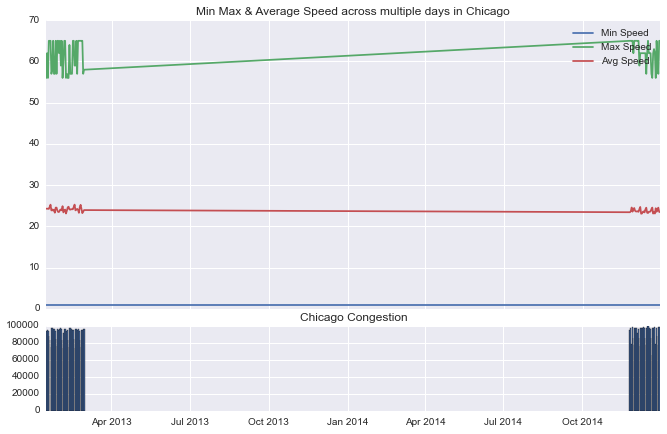

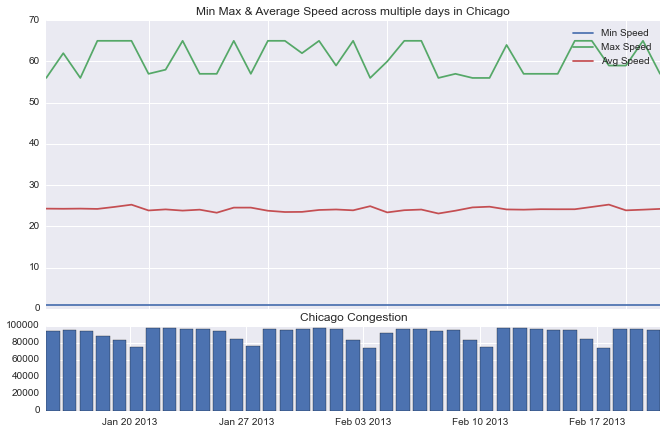

In [83]:
import numpy as np
df_conges_aggregate=date_groupby.aggregate(np.mean)
df_conges_aggregate.head(2)

,SEGMENTID,BUS COUNT,MESSAGE COUNT,SPEED
DATE,,,,
2011-10-27,1194.000000,1.00000,1.000000,-1.000000
2013-01-15,565.165932,1.84412,10.022824,24.276142


# Historical Data Analysis by Region

In [4]:
df_region_hist=getData('Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Region.csv')
df_region_current=getData('Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Regions.csv')

In [363]:
df_region_hist.head(2)


,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID
0,01/31/2015 11:50:26 PM,1,9,135,26.59,bf2f4db8f620658c9a084918c964883479c594f9
1,01/31/2015 11:50:26 PM,1,19,257,21.14,75455d6eb934e4ef4ba965e3a3f913e5ba1c16fe


In [364]:
df_region_hist.tail(2)

,TIME,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID
3179964,01/18/2013 11:50:26 PM,29,1,14,0.00,90c77f407f063ac107dc3396e429e9da4a080944
3179965,01/18/2013 11:50:26 PM,29,97,880,23.18,6ed9793b50e023386e7ef33effeb8a0a5fcb870b


In [365]:
df_region_current.head(2)

,REGION,REGION_ID,WEST,EAST,SOUTH,NORTH,DESCRIPTION,CURRENT_SPEED,LAST_UPDATED
0,Rogers Park - West Ridge,1,-87.709645,-87.654561,41.997946,42.026444,North of Devon. Kedzie to Lake Shore,24.55,2016-02-13 19:50:34.0
1,Far North West,2,-87.846210,-87.747456,41.960669,42.019100,North of Montrose. East River to Cicero,25.91,2016-02-13 19:50:34.0


In [5]:
import datetime as dt
format = '%m/%d/%Y %I:%M:%S %p'
df_region_hist['DATE'] = df_region_hist['TIME'].apply(lambda x: 
                                    dt.datetime.strptime(x,format).date())

df_region_hist['TIMESTAMP'] = df_region_hist['TIME'].apply(lambda x: 
                                    dt.datetime.strptime(x,format).time())
df_region_hist.head(2)
## Filter out data with no GPS data and look at records with and without midnight timestamps
df_region_hist=df_region_hist.rename(columns = {'NUMBER OF READS                      ':'NUMBER OF READS'})
df_region_hist = df_region_hist[(df_region_hist['NUMBER OF READS'] > 0)]
df_conges_nonmidnight = df_region_hist[(df_region_hist['TIMESTAMP'] < dt.time(23, 50, 00))]

# print 'non-midnight data: ', df_conges_nonmidnight.shape
# print 'all data:', df_region_hist.shape
# ## Only 128K records out of 3.2M records have non-midnight timestamps.

# ## ADD FLAG FOR MIDNIGHT AND NON-MIDNIGHT DATA AND COUNT INSTANCES
df_region_hist['MIDNIGHT FLAG'] = (df_region_hist['TIMESTAMP'] > dt.time(23, 50, 00))
date_timestamp_groupby=df_region_hist.groupby(['MIDNIGHT FLAG','DATE'])
date_time_count = date_timestamp_groupby.count()



In [26]:
if 'TIME' in df_region_hist.columns:
    df_region_hist = df_region_hist.drop(['TIME'],1)
df_region_hist.tail(50)

,REGION_ID,BUS COUNT,NUMBER OF READS,SPEED,ID,DATE,TIMESTAMP,MIDNIGHT FLAG
3179916,29,55,433,24.00,d5832583ef774c857dab9a72ed39dc87c4228989,2013-01-18,23:50:26,True
3179917,29,16,118,22.50,48ba0cab83b22783697ac759ba0e6c766130c9eb,2013-01-18,23:50:26,True
3179918,29,35,268,24.55,34a7e6498906d04dbba7e7c71aadace86dea037d,2013-01-18,23:50:26,True
3179919,29,3,17,0.00,6d6ed53b9cd3d1037a4514df82fff56ae6c8dc71,2013-01-18,23:50:26,True
3179920,29,2,19,0.00,021a0ab16afaf21143825b02e278da47267c9783,2013-01-18,23:50:26,True
3179921,29,26,242,19.70,48fcca83cabfa123277062fab1016c84c026734a,2013-01-18,23:50:26,True
3179922,29,43,381,24.55,e7281ad39433a43629d130bf2b3bc8ae28ab7c7a,2013-01-18,23:50:26,True
3179923,29,25,219,23.18,b1b6162d31374f3a44170469ce760854efccad79,2013-01-18,23:50:26,True
3179924,29,11,77,21.41,e1a185c58ab63cf44905ff333fa76abab8ec30f5,2013-01-18,23:50:26,True
3179925,29,14,111,19.77,c7c71c2e02b9e90181a104ace342b4964945c1ca,2013-01-18,23:50:26,True


In [7]:
import numpy as np
regionid_groupby=df_region_hist.groupby(['DATE','REGION_ID'])['SPEED'].mean()
#regionid_groupby['DATE'].head(30)
regionid_groupby_date_id = regionid_groupby.reset_index()
regionid_groupby_date_id.head(2)

,DATE,REGION_ID,SPEED
0,2013-01-18,1,19.801016
1,2013-01-18,2,26.778550


In [47]:

df_date_speed=df_region_hist[['DATE','SPEED']]
df_date_speed=df_date_speed[df_date_speed.SPEED>0]
df_date_speed.head(2)

date_speed_groupby=df_date_speed.groupby(['DATE'])
average_speed_day=date_speed_groupby.aggregate(np.mean)
average_speed_day.reset_index(level=0, inplace=True)
max_speed_day=date_speed_groupby.aggregate(np.max)
max_speed_day.reset_index(level=0, inplace=True)
min_speed_day=date_speed_groupby.aggregate(np.min)
min_speed_day.reset_index(level=0, inplace=True)

df_date_buscount=df_region_hist[['DATE','BUS COUNT']]
date_buscount_groupby=df_date_buscount.groupby(['DATE'])
bus_count_day=date_buscount_groupby.aggregate(np.count_nonzero)
bus_count_day.reset_index(level=0, inplace=True)

df_min_max_speed = pd.merge(left=min_speed_day,right=max_speed_day, how='left', left_on='DATE', right_on='DATE')
df_min_max_speed_avg= pd.merge(left=df_min_max_speed,right=average_speed_day, how='left', left_on='DATE', right_on='DATE')

df_min_max_speed_avg_count= pd.merge(left=df_min_max_speed_avg,right=bus_count_day, how='left', left_on='DATE', right_on='DATE')
df_min_max_speed_avg_count=df_min_max_speed_avg_count.rename(columns = {'SPEED_x':'Min Speed','SPEED_y':'Max Speed','SPEED':'Avg Speed'})



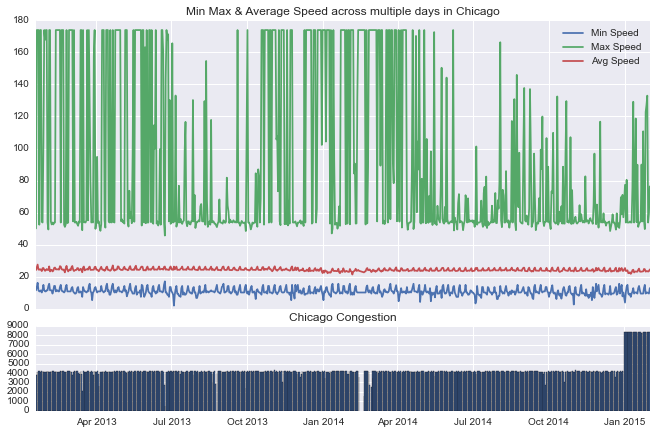

In [48]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
def plotdata(df):
    plt.rcParams['figure.figsize'] = 11, 7
    df_all_traffic=df.set_index('DATE')
    main = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
    main.plot(df_all_traffic.index, df_all_traffic['Min Speed'], label='Min Speed')
    main.plot(df_all_traffic.index, df_all_traffic['Max Speed'], label='Max Speed')
    main.plot(df_all_traffic.index, df_all_traffic['Avg Speed'], label='Avg Speed')
    main.axes.xaxis.set_ticklabels([])

    plt.title('Min Max & Average Speed across multiple days in Chicago')
    plt.legend()
    buscount = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
    buscount.bar(df_all_traffic.index, df_all_traffic['BUS COUNT'])

    plt.title('Chicago Congestion ')
plotdata(df_min_max_speed_avg_count)

In [ ]:
import numpy as np
regionid_groupby=df_region_hist.groupby(['DATE','REGION_ID'])['SPEED'].mean()
#regionid_groupby['DATE'].head(30)
regionid_groupby_date_id = regionid_groupby.reset_index()
regionid_groupby_date_id.head(2)

In [27]:
# Non Mid Night Data
df_region_hist_temp=df_region_hist[df_region_hist['MIDNIGHT FLAG']!=True]
df_region_hist_temp.head(2)

df_conges_Reg_Jan2015 = df_region_hist_temp[df_region_hist_temp['DATE'] <= dt.date(2015,1,31)]
df_conges_Reg_Jan2015.shape


## Analysis for multiple time periods per day (10 minute interval)

In [28]:
df_region_all_Jan2015=pd.merge(left=df_conges_Reg_Jan2015,right=df_region_current, how='left', left_on='REGION_ID', 
                               right_on='REGION_ID')
df_region_all_Jan2015.columns

Index([u'REGION_ID', u'BUS COUNT', u'NUMBER OF READS', u'SPEED', u'ID',
       u'DATE', u'TIMESTAMP', u'MIDNIGHT FLAG', u'REGION', u'WEST', u'EAST',
       u'SOUTH', u'NORTH', u'DESCRIPTION', u'CURRENT_SPEED', u'LAST_UPDATED'],
      dtype='object')

In [31]:

df_date_speed=df_region_all_Jan2015[['DATE','SPEED']]
df_date_speed=df_date_speed[df_date_speed.SPEED>0]
df_date_speed.head(2)

date_speed_groupby=df_date_speed.groupby(['DATE'])
average_speed_day=date_speed_groupby.aggregate(np.mean)
average_speed_day.reset_index(level=0, inplace=True)
max_speed_day=date_speed_groupby.aggregate(np.max)
max_speed_day.reset_index(level=0, inplace=True)
min_speed_day=date_speed_groupby.aggregate(np.min)
min_speed_day.reset_index(level=0, inplace=True)

df_date_buscount=df_region_all_Jan2015[['DATE','BUS COUNT']]
date_buscount_groupby=df_date_buscount.groupby(['DATE'])
bus_count_day=date_buscount_groupby.aggregate(np.count_nonzero)
bus_count_day.reset_index(level=0, inplace=True)

df_min_max_speed = pd.merge(left=min_speed_day,right=max_speed_day, how='left', left_on='DATE', right_on='DATE')
df_min_max_speed_avg= pd.merge(left=df_min_max_speed,right=average_speed_day, how='left', left_on='DATE', right_on='DATE')

df_min_max_speed_avg_count= pd.merge(left=df_min_max_speed_avg,right=bus_count_day, how='left', left_on='DATE', right_on='DATE')
df_min_max_speed_avg_count=df_min_max_speed_avg_count.rename(columns = {'SPEED_x':'Min Speed','SPEED_y':'Max Speed','SPEED':'Avg Speed'})



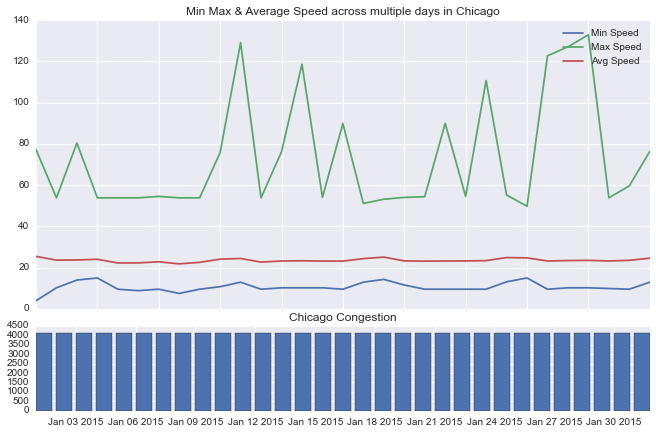

In [32]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
def plotdata(df):
    plt.rcParams['figure.figsize'] = 11, 7
    df_all_traffic=df.set_index('DATE')
    main = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
    main.plot(df_all_traffic.index, df_all_traffic['Min Speed'], label='Min Speed')
    main.plot(df_all_traffic.index, df_all_traffic['Max Speed'], label='Max Speed')
    main.plot(df_all_traffic.index, df_all_traffic['Avg Speed'], label='Avg Speed')
    main.axes.xaxis.set_ticklabels([])

    plt.title('Min Max & Average Speed across multiple days in Chicago')
    plt.legend()
    buscount = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
    buscount.bar(df_all_traffic.index, df_all_traffic['BUS COUNT'])

    plt.title('Chicago Congestion ')
plotdata(df_min_max_speed_avg_count)

## Load Eventa Data

In [33]:
# Merge with event data
from datetime import datetime
event_data=getData('BullsGameData.csv')
format = '%m/%d/%Y'
event_data['DATE'] = event_data['Date'].apply(lambda x: 
                                    dt.datetime.strptime(x,format).date())
if 'Date' in event_data.columns:
    event_data.drop('Date', axis=1, inplace=True)

# For Testing
event_data.head(2)
# event_data[event_data['DATE']==date(2015,1,3)]
# event_data['DATE'][0]


,GameNum,Time,AwayFlag,Opponent,Result,OT,Lat,Long,DATE
0,2,NaN,NaN,New York Knicks,W,NaN,41.880556,-87.674167,2013-10-31
1,5,NaN,NaN,Utah Jazz,W,NaN,41.880556,-87.674167,2013-11-08


In [ ]:
# Merge with Event Data

In [34]:

df_region_Jan2015_event=pd.merge(left=df_region_all_Jan2015,right=event_data, how='left', left_on='DATE', right_on='DATE')

if 'GameNum' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('GameNum', axis=1, inplace=True)
if 'Opponent' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('Opponent', axis=1, inplace=True)
if 'Result' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('Result', axis=1, inplace=True)
if 'OT' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('OT', axis=1, inplace=True)
if 'CURRENT_SPEED' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('CURRENT_SPEED', axis=1, inplace=True)
if 'NUMBER OF READS' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('NUMBER OF READS', axis=1, inplace=True)


df_region_Jan2015_event.columns




Index([u'REGION_ID', u'BUS COUNT', u'SPEED', u'ID', u'DATE', u'TIMESTAMP',
       u'MIDNIGHT FLAG', u'REGION', u'WEST', u'EAST', u'SOUTH', u'NORTH',
       u'DESCRIPTION', u'LAST_UPDATED', u'Time', u'AwayFlag', u'Lat', u'Long'],
      dtype='object')

In [35]:
df_region_Jan2015_event.head(2)

,REGION_ID,BUS COUNT,SPEED,ID,DATE,TIMESTAMP,MIDNIGHT FLAG,REGION,WEST,EAST,SOUTH,NORTH,DESCRIPTION,LAST_UPDATED,Time,AwayFlag,Lat,Long
0,1,10,21.48,0f4650c1b521064d9c2bc124db3a3914125c3713,2015-01-31,23:40:16,False,Rogers Park - West Ridge,-87.709645,-87.654561,41.997946,42.026444,North of Devon. Kedzie to Lake Shore,2016-02-13 19:50:34.0,NaN,NaN,NaN,NaN
1,2,11,22.23,2783f94f0c7bb1dd368bfe719516b975daf3d17a,2015-01-31,23:40:16,False,Far North West,-87.846210,-87.747456,41.960669,42.019100,North of Montrose. East River to Cicero,2016-02-13 19:50:34.0,NaN,NaN,NaN,NaN


In [36]:
#df_region_Jan2015_event.drop('HasGame', axis=1, inplace=True)
df_region_Jan2015_event['HasGame'] = df_region_Jan2015_event.apply(lambda x : 1 if str(x['Lat'])[1:5]==str(x['NORTH'])[1:5]
                                                                   else 0, axis=1)


### Changing the variable names 

In [37]:
if 'ID' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('ID', axis=1, inplace=True)
if 'WEST' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('WEST', axis=1, inplace=True)
if 'SOUTH' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('SOUTH', axis=1, inplace=True)
if 'Lat' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('Lat', axis=1, inplace=True)
if 'Long' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('Long', axis=1, inplace=True)
if 'AwayFlag' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('AwayFlag', axis=1, inplace=True)
if 'LAST_UPDATED' in df_region_Jan2015_event.columns:
    df_region_Jan2015_event.drop('LAST_UPDATED', axis=1, inplace=True)


# Default Posted Speed
df_region_Jan2015_event['POSTEDSPEED']=30
df_region_Jan2015_event.rename(columns = {'EAST':'LONGTITUDE'},inplace=True)
df_region_Jan2015_event.rename(columns = {'NORTH':'LATITUDE'},inplace=True)
df_region_Jan2015_event.head(1)

,REGION_ID,BUS COUNT,SPEED,DATE,TIMESTAMP,MIDNIGHT FLAG,REGION,LONGTITUDE,LATITUDE,DESCRIPTION,Time,HasGame,POSTEDSPEED
0,1,10,21.48,2015-01-31,23:40:16,False,Rogers Park - West Ridge,-87.654561,42.026444,North of Devon. Kedzie to Lake Shore,NaN,0,30


### Traffic Event Data

In [38]:
df_region_Jan2015_event.to_csv("Jan2015_data.csv")

# Analysis for regions for average congestion per day for a region

In [42]:
df_region_all=pd.merge(left=regionid_groupby_date_id,right=df_region_current, how='left', left_on='REGION_ID', right_on='REGION_ID')


In [43]:
df_region_all['SPEED']=df_region_all['SPEED'].astype(int)
df_region_all['CONGESTION'] = None
condition_slow = (df_region_all['SPEED'] >=-1) & (df_region_all['SPEED'] <=9)
df_region_all.loc[condition_slow, 'CONGESTION'] = 10
condition_medium = (df_region_all['SPEED'] >=10) & (df_region_all['SPEED'] <=20)
df_region_all.loc[condition_medium, 'CONGESTION'] = 5
condition_fast = (df_region_all['SPEED'] >=21)
df_region_all.loc[condition_fast, 'CONGESTION'] = 1

In [12]:
df_region_all.columns

Index([u'DATE', u'REGION_ID', u'SPEED', u'REGION', u'WEST', u'EAST', u'SOUTH',
       u'NORTH', u'DESCRIPTION', u'CURRENT_SPEED', u'LAST_UPDATED',
       u'CONGESTION'],
      dtype='object')

In [128]:
# Congestion for different regions for a given date

In [44]:
import folium
import datetime as dt
date_const=dt.date(2013,1,18)
df_region_date=df_region_all[df_region_all.DATE==date_const]

congestion_data=df_region_date[['SOUTH','WEST','CONGESTION']].values



In [ ]:
# Congestion across dates for a given region

In [45]:
gmaps.heatmap(congestion_data)

In [ ]:
gmaps.heatmap(congestion_data)

In [25]:
date_const=dt.date(2013,10,18)
df_region_date=df_region_all[df_region_all.DATE==date_const]
congestion_data=df_region_date[['SOUTH','WEST','CONGESTION']].values

In [26]:
gmaps.heatmap(congestion_data)

In [22]:
df_region_all[df_region_all.REGION_ID==1].head(2)

,DATE,REGION_ID,SPEED,REGION,WEST,EAST,SOUTH,NORTH,DESCRIPTION,CURRENT_SPEED,LAST_UPDATED,CONGESTION
0,2013-01-18,1,19,Rogers Park - West Ridge,-87.709645,-87.654561,41.997946,42.026444,North of Devon. Kedzie to Lake Shore,24.55,2016-02-13 19:50:34.0,5
29,2013-01-19,1,19,Rogers Park - West Ridge,-87.709645,-87.654561,41.997946,42.026444,North of Devon. Kedzie to Lake Shore,24.55,2016-02-13 19:50:34.0,5


In [23]:
df_region_all[df_region_all.REGION_ID==2].head(2)

,DATE,REGION_ID,SPEED,REGION,WEST,EAST,SOUTH,NORTH,DESCRIPTION,CURRENT_SPEED,LAST_UPDATED,CONGESTION
1,2013-01-18,2,26,Far North West,-87.84621,-87.747456,41.960669,42.0191,North of Montrose. East River to Cicero,25.91,2016-02-13 19:50:34.0,1
30,2013-01-19,2,27,Far North West,-87.84621,-87.747456,41.960669,42.0191,North of Montrose. East River to Cicero,25.91,2016-02-13 19:50:34.0,1


In [192]:
df_region_select.head(2)

,DATE,REGION_ID,SPEED,REGION,WEST,EAST,SOUTH,NORTH,DESCRIPTION,CURRENT_SPEED,LAST_UPDATED,CONGESTION
0,2013-01-18,1,19,Rogers Park - West Ridge,-87.709645,-87.654561,41.997946,42.026444,North of Devon. Kedzie to Lake Shore,24.55,2016-02-13 19:50:34.0,5
29,2013-01-19,1,19,Rogers Park - West Ridge,-87.709645,-87.654561,41.997946,42.026444,North of Devon. Kedzie to Lake Shore,24.55,2016-02-13 19:50:34.0,5


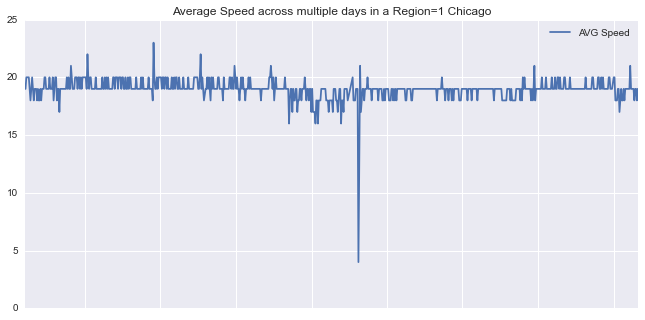

In [214]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
def plotdata(df,regionid):
    plt.rcParams['figure.figsize'] = 11, 7
    df_all_traffic=df[df.REGION_ID==regionid]
    df_all_traffic=df_all_traffic.set_index('DATE')
    main = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
    main.plot(df_all_traffic.index, df_all_traffic['SPEED'], label='AVG Speed')
    main.axes.xaxis.set_ticklabels([])

    plt.title('Average Speed across multiple days in a Region='+str(regionid)+' Chicago')
    plt.legend()
plotdata(df_region_all,1)


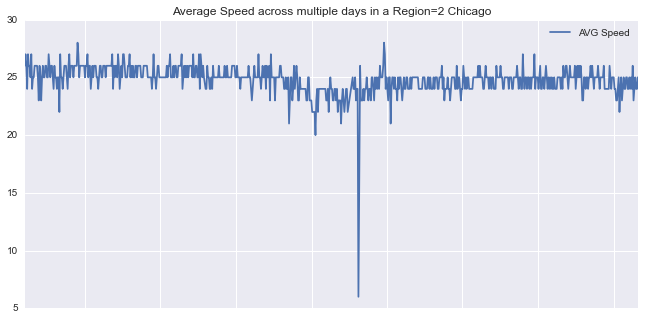

In [215]:
plotdata(df_region_all,2)

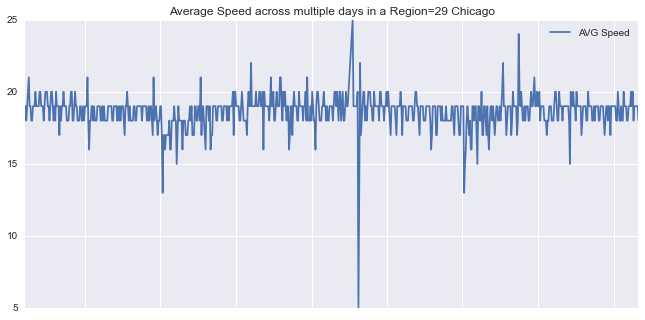

In [216]:
plotdata(df_region_all,29)

In [217]:
# Congestion across timeperiod for different regions

In [18]:
import numpy as np
regionid_groupby=df_region_hist.groupby(['REGION_ID'])['SPEED'].mean()
#regionid_groupby['DATE'].head(30)
regionid_groupby_date_id = regionid_groupby.reset_index()
regionid_groupby_date_id.head(2)

,REGION_ID,SPEED
0,1,19.443815
1,2,25.214101


In [219]:
df_region_all=pd.merge(left=regionid_groupby_date_id,right=df_region_current, how='left', left_on='REGION_ID', right_on='REGION_ID')


In [19]:
df_region_all['SPEED']=df_region_all['SPEED'].astype(int)
df_region_all['CONGESTION'] = None
condition_slow = (df_region_all['SPEED'] >=-1) & (df_region_all['SPEED'] <=9)
df_region_all.loc[condition_slow, 'CONGESTION'] = 10
condition_medium = (df_region_all['SPEED'] >=10) & (df_region_all['SPEED'] <=20)
df_region_all.loc[condition_medium, 'CONGESTION'] = 5
condition_fast = (df_region_all['SPEED'] >=21)
df_region_all.loc[condition_fast, 'CONGESTION'] = 1

In [20]:
df_region_all.head(2)
congestion_data=df_region_all[['SOUTH','WEST','CONGESTION']].values

In [225]:
import gmaps

In [21]:
gmaps.heatmap(congestion_data)

# Another way of Getting Region data for multiple time intervals ( Latest Data)

In [47]:
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
url='https://data.cityofchicago.org/resource/historical-traffic-congestion-region.json?region_id='
def generateData(url):
    appended_data = []
    for id in range(1,29):
        data = pd.read_json(url+str(id))
        appended_data.append(data) ## store dataframes in list
    return appended_data
appended_data=generateData(url)
congestion_df = pd.concat(appended_data, axis=0) 
print congestion_df.tail(2)


     bus_count  number_of_reads  region_id  speed                 time
998          9              121         28  38.86  2015-01-19T14:40:42
999          7              108         28  34.53  2015-01-07T12:01:32


In [54]:
# Splitting Data into Morning,Afternoon,Evening & Night

In [9]:
import datetime as dt
format = "%Y-%m-%dT%H:%M:%S"
df_region_congestion['HOURS'] = None

df_region_congestion['HOURS'] = df_region_congestion['time'].apply(lambda x: 
                                    dt.datetime.strptime(x,format).time().hour)

